In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="0,1"
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from utils import create_submission,BASE_SIZE,drawing2tensor,list2drawing,map3
from MobileNetV2 import MobileNetV2 as Mbnet

In [3]:
torch.cuda.device_count()

2

In [4]:
NUM_SAMPLES_PER_CLASS = 40_000
NUM_VAL = 50 * 900

In [5]:
sz = 64;bs=400

In [6]:
path = Path('data/txt')

In [7]:
def cf(path):
    with open(path) as f: j = json.load(f)
    dr = list2drawing(j['drawing'],size=sz,time_color=True)
    return Image(drawing2tensor(dr).div_(255))

In [8]:
np.random.seed(42)

In [ ]:
itemlst = ItemList.from_folder(path/'train',create_func=cf)

idx_vals = np.arange(itemlst.items.shape[0])
np.random.shuffle(idx_vals)
VAL_IDX = idx_vals[:NUM_VAL]
itemlsts = itemlst.split_by_idx(VAL_IDX)

lblst = itemlsts.label_from_folder()
tst_item = ItemList.from_folder('data/test',create_fn=cf)

lblst.add_test(tst_item);

train_dl = DataLoader(lblst.train, bs, True, num_workers=20)
valid_dl = DataLoader(lblst.valid, 2*bs, False, num_workers=8)
test_dl = DataLoader(lblst.test, 2*bs, False, num_workers=8)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)
data_bunch.normalize(data_bunch.batch_stats());

In [ ]:
itemlst

In [ ]:
data_bunch.normalize(data_bunch.batch_stats());

In [ ]:
data_bunch.show_batch(rows=3,figsize=(7,7))

In [15]:
name = f'mb-res50-{sz}-2'

In [16]:
def nett(pretrained):
    net = Mbnet(1000,sz)
    net.load_state_dict(torch.load('./mobilenet_v2.pth.tar'))
    return net

# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][0][4],m[1])

In [18]:
learn = create_cnn(data_bunch, 
                   nett,
                   cut=-1,
                   pretrained=False,
                   split_on=_resnet_split,
                   metrics=[accuracy, map3]
                  ).to_fp16()

learn.freeze()

In [19]:
learn.model = nn.DataParallel(learn.model)

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


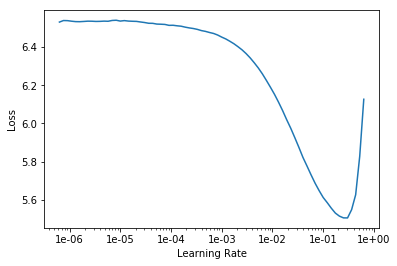

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2,4e-2)

Total time: 08:04
epoch  train_loss  valid_loss  accuracy  map3    
1      1.945155    2.010890    0.511311  0.604863  (04:06)
2      1.482223    1.299025    0.676022  0.753111  (03:58)



In [23]:
name

'mb-res50-64-2'

In [24]:
torch.save(learn.model.module.state_dict(),f'models/mb-{name}-stage-1-128.pth')

In [25]:
learn.fit_one_cycle(2,4e-2)

Total time: 07:46
epoch  train_loss  valid_loss  accuracy  map3    
1      1.916353    1.986349    0.517311  0.609715  (03:55)
2      1.462002    1.290103    0.678133  0.754467  (03:51)



In [26]:
learn.unfreeze()

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


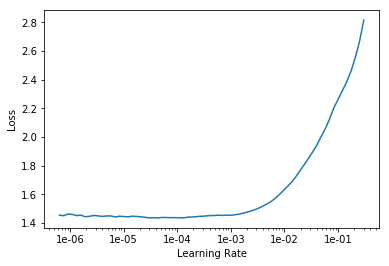

In [28]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(2,slice(1e-4,1e-3))

Total time: 09:38
epoch  train_loss  valid_loss  accuracy  map3    
1      1.306612    1.164639    0.704533  0.777685  (04:48)
2      1.172364    1.065390    0.731422  0.799296  (04:50)



In [31]:
learn.fit_one_cycle(2,slice(5e-5,3e-4))

Total time: 09:36
epoch  train_loss  valid_loss  accuracy  map3    
1      1.154790    1.050748    0.734044  0.802178  (04:45)
2      1.101200    1.022604    0.741422  0.807804  (04:51)



In [32]:
torch.save(learn.model.module.state_dict(),f'models/mb-{name}-stage-1-64.pth')

In [36]:
sz = 96;bs=1200

itemlst = ItemList.from_folder(path/'train',create_func=cf)

idx_vals = np.arange(itemlst.items.shape[0])
np.random.shuffle(idx_vals)
VAL_IDX = idx_vals[:NUM_VAL]
itemlsts = itemlst.split_by_idx(VAL_IDX)

lblst = itemlsts.label_from_folder()
tst_item = ItemList.from_folder('data/test',create_fn=cf)

lblst.add_test(tst_item);

train_dl = DataLoader(lblst.train, bs, True, num_workers=28)
valid_dl = DataLoader(lblst.valid, 2*bs, False, num_workers=12)
test_dl = DataLoader(lblst.test, 2*bs, False, num_workers=8)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)
data_bunch.normalize(data_bunch.batch_stats());

learn.data = data_bunch

name = 'mb-res50-96-2'

In [41]:
learn.freeze()

learn.lr_find()

learn.recorder.plot()

In [44]:
learn.fit_one_cycle(2,1e-2)

Total time: 11:41
epoch  train_loss  valid_loss  accuracy  map3    
1      1.190237    1.062694    0.729489  0.800218  (05:53)
2      1.110482    0.964572    0.753244  0.819337  (05:48)



In [45]:
torch.save(learn.model.module.state_dict(),f'models/mb-{name}-stage-1-96.pth')

In [46]:
learn.unfreeze()

In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


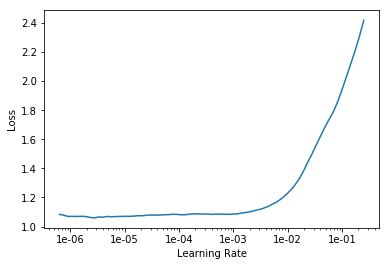

In [48]:
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(4,slice(3e-5,4e-4))

Total time: 28:24
epoch  train_loss  valid_loss  accuracy  map3    
1      1.074097    0.949536    0.756844  0.822326  (07:02)
2      1.043441    0.927146    0.761667  0.826167  (07:02)
3      1.009691    0.903319    0.767889  0.831248  (07:02)
4      0.986948    0.897300    0.769044  0.832196  (07:17)



In [50]:
torch.save(learn.model.module.state_dict(),f'models/mb-{name}-stage-2-96.pth')

In [51]:
learn.fit_one_cycle(2,slice(4e-5,5e-4))

Total time: 14:06
epoch  train_loss  valid_loss  accuracy  map3    
1      1.014488    0.912822    0.765822  0.829178  (07:02)
2      0.964727    0.884482    0.772778  0.834918  (07:03)



In [52]:
torch.save(learn.model.module.state_dict(),f'models/mb-{name}-stage-3-96.pth')

In [72]:
sz = 128;bs=1024

itemlst = ItemList.from_folder(path/'train',create_func=cf)

idx_vals = np.arange(itemlst.items.shape[0])
np.random.shuffle(idx_vals)
VAL_IDX = idx_vals[:NUM_VAL]
itemlsts = itemlst.split_by_idx(VAL_IDX)

lblst = itemlsts.label_from_folder()
tst_item = ItemList.from_folder('data/txt/test',create_fn=cf)

lblst.add_test(tst_item);

train_dl = DataLoader(lblst.train, bs, True, num_workers=28)
valid_dl = DataLoader(lblst.valid, 2*bs, False, num_workers=12)
test_dl = DataLoader(lblst.test, 2*bs, False, num_workers=8)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)
data_bunch.normalize(data_bunch.batch_stats());

learn.data = data_bunch

name = 'mb-res50-128-2'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


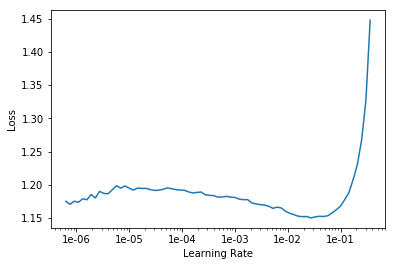

In [54]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(1,6e-3)

Total time: 09:13
epoch  train_loss  valid_loss  accuracy  map3    
1      1.005238    0.910745    0.767822  0.830559  (09:13)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


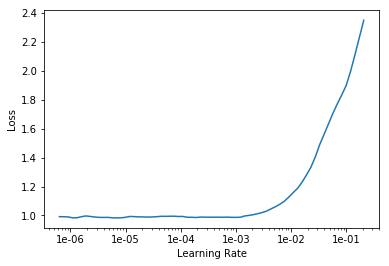

In [56]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [57]:
learn.fit_one_cycle(4,slice(4e-5,8e-4))

Total time: 43:53
epoch  train_loss  valid_loss  accuracy  map3    
1      0.993872    0.923558    0.762933  0.827163  (10:53)
2      0.986114    0.905295    0.767800  0.830715  (10:55)
3      0.920867    0.874620    0.775644  0.837341  (11:01)
4      0.892130    0.863923    0.778356  0.839256  (11:02)



In [58]:
torch.save(learn.model.module.state_dict(),f'models/mb-{name}-stage-1-128.pth')

In [61]:
learn.model.module.load_state_dict(torch.load(f'models/mb-{name}-stage-1-128.pth'))

In [62]:
learn.fit_one_cycle(4,slice(5e-5,9e-4))

Total time: 43:41
epoch  train_loss  valid_loss  accuracy  map3    
1      0.944988    0.899895    0.769622  0.832526  (10:54)
2      0.940805    0.892916    0.771689  0.834056  (10:52)
3      0.873428    0.859324    0.778844  0.839933  (10:57)
4      0.854737    0.848291    0.782111  0.842530  (10:57)



In [63]:
torch.save(learn.model.module.state_dict(),f'models/mb-{name}-stage-2-128.pth')

In [64]:
name

'mb-res50-128-2'

In [ ]:
torch.save(learn.model.module.state_dict(),f'models/{name}-stage-8-224.pth')

## Predict

In [75]:
learn = create_cnn(data_bunch, models.resnet50, metrics=[accuracy, map3]).to_fp16()

In [78]:
learn.model = nn.DataParallel(learn.model)

In [ ]:
learn.model.module.load_state_dict(torch.load(f'models/mb-{name}-stage-2-128.pth'))

In [ ]:
# learn.model.load_state_dict(torch.load(f'models/res50-128-44-stage-2-128.pth'))

In [73]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.HalfTensor) should be the same

In [ ]:
create_submission(preds, data_bunch.test_dl, name, data_bunch.y.classes)

In [ ]:
pd.read_csv(f'subs/{name}.csv.gz').head()

In [ ]:
!kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}-2v100"